# **Read dataset**

In [1]:
path_train = './data/train.csv'
path_test = './data/test.csv'
path_example_out = './data/sample_submission.csv'

In [2]:
import pandas as pd

In [3]:
data = pd.read_csv(path_train)
print(data[:6])

                      Id  Category  \
0  6,35769805279248E+017  negative   
1  6,35930169241375E+017   neutral   
2  6,35950258682524E+017   neutral   
3  6,36030803433009E+017  negative   
4  6,36100906224849E+017  positive   
5  6,36176272947745E+017   neutral   

                                               Tweet  
0                                      Not Available  
1  IOS 9 App Transport Security. Mm need to check...  
2  Mar if you have an iOS device, you should down...  
3  @jimmie_vanagon my phone does not run on lates...  
4  Not sure how to start your publication on iOS?...  
5  Two Dollar Tuesday is here with Forklift 2, Qu...  


# **Analyse**

In [4]:
import seaborn as sns

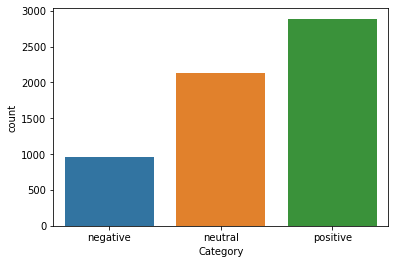

In [5]:
sns.countplot(x= 'Category',data = data)

# **Vertorize tweets**

In [6]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import math

[nltk_data] Downloading package punkt to /home/jaroslaw/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jaroslaw/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Clean tweet method**

In [7]:
def clean_tweet(tweet):
    tweet_list = [ele for ele in tweet.lower().split()]
    clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
    clean_s = ' '.join(clean_tokens)
    clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english')]
    return clean_mess

**Normalization tokens method**

In [8]:
def normalization(clean_tokens):
        lem = WordNetLemmatizer()
        normalized_tweet = []
        for tokens in clean_tokens:
            normalized_text = lem.lemmatize(tokens,'v')
            normalized_tweet.append(normalized_text)
        return normalized_tweet

In [16]:
clean_tokens = [[item['Id'], clean_tweet(item['Tweet'].lower())] for (index, item) in data.iterrows()]

In [17]:
print(clean_tokens[10])

['6,36440904967062E+017', ['parkrun', 'app', 'ios', 'downloaded', 'app', 'easier', 'access', 'info', 'ready', 'run']]


In [18]:
normalize_tokens = [[id, normalization(tokens)] for (id, tokens) in clean_tokens]

In [19]:
print(normalize_tokens[10])

['6,36440904967062E+017', ['parkrun', 'app', 'ios', 'download', 'app', 'easier', 'access', 'info', 'ready', 'run']]


**Get unique tokens method**

In [20]:
def unique_tokens(token_list):
    token_set = set()
    for (id, tokens) in token_list:
        for item in tokens:
            token_set.add(item)
    return token_set

In [21]:
print(len(unique_tokens(normalize_tokens)))

7073


In [22]:
unique_set = unique_tokens(normalize_tokens)
pattern_unique_map = {item: 0 for item in unique_set} 
sorted_unique_set = sorted(unique_set)
list_unique = list(sorted_unique_set)
# print(pattern_unique_map)
# new_map = pattern_unique_map.copy()
# new_map['prosecutor'] = new_map['prosecutor'] + 1
# print(patter_unique_map['prosecutor'])
# print(new_map['prosecutor'])

**Count idf for token and tokens_list method**

In [23]:
def count_idf(token, tokens_list):
    number_of_documents = len(tokens_list)
    term_in_documents = 0
    for (id, tokens) in tokens_list:
        for t in tokens:
            if t == token:
                term_in_documents += 1
                break
    return math.log2(number_of_documents/term_in_documents)

**Test count_idf for a few words**

In [24]:
print(count_idf('prosecutor', normalize_tokens))
print(count_idf('bye', normalize_tokens))
print(count_idf('general', normalize_tokens))
print(count_idf('much', normalize_tokens))
print(count_idf('baby', normalize_tokens))

12.543273538449803
10.958311037728647
10.221345443562441
6.100330042601075
8.543273538449803


**Count idfs for all unique tokens**

In [25]:
idf_list = pd.DataFrame(
    [count_idf(item, normalize_tokens) 
     for item in sorted_unique_set], 
    index=list_unique, 
    columns=['Values'])

In [26]:
print(idf_list.head())

            Values
aa       11.543274
aaa      12.543274
ab       12.543274
abandon  11.543274
abbott   12.543274


**Count tf for term vector**

In [52]:
def count_tf_vector(term_vector):
    tf_vector_map = pattern_unique_map.copy()
    for term in term_vector:
        if term in tf_vector_map:
            tf_vector_map[term] += 1
    return pd.DataFrame(
        [value for key, value in iter(sorted(tf_vector_map.items()))], 
        index=list(sorted_unique_set),
        columns=['Values'])

**Multiply tf x idf**

In [28]:
def multiply_tf_idf(tf_df, idf_df):
    return tf_df.mul(idf_df)

# **Prepare data to train**

In [29]:
def transform_tweet(tweet):
    return count_tf_vector(normalization(clean_tweet(tweet.lower())))    

In [30]:
train_data = [
    [item['Id'], 
     item['Category'], 
     pd.DataFrame(multiply_tf_idf(transform_tweet(item['Tweet'].lower()), idf_list).transpose(), columns=list_unique)] 
              for (index, item) in data.iterrows()]

In [31]:
train_vectors = pd.concat([df for (id, label, df) in train_data])
train_vectors.index = [id for (id, label, df) in train_data]

train_label = pd.DataFrame([label for (id, label, df) in train_data], index=[id for (id, label, df) in train_data], columns=['labels'])

# **Dimensional reduction**

In [32]:
from sklearn.decomposition import PCA

In [33]:
pca = PCA(n_components=500)
pca.fit(train_vectors)
X_pca = pca.transform(train_vectors)
print("original shape:   ", train_vectors.shape)
print("transformed shape:", X_pca.shape)

original shape:    (5969, 7073)
transformed shape: (5969, 500)


# **Divide to test and train set**

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, train_label, test_size=0.1, random_state=123)

In [36]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5372, 500)
(597, 500)
(5372, 1)
(597, 1)


# **Train classifier**

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [89]:
random_forest = RandomForestClassifier(n_estimators = 1000, 
                                       random_state = 123, 
                                       n_jobs=-1, 
                                       verbose=1)

In [90]:
random_forest.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   34.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=1,
                       warm_start=False)

# **Predict**

In [40]:
from sklearn import datasets, metrics
import matplotlib.pyplot as plt

In [91]:
y_pred = random_forest.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.3s finished


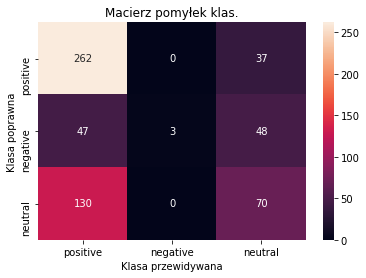

In [42]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred, labels=y_train['labels'].unique())

df = pd.DataFrame(conf_matrix, index=y_train['labels'].unique(), columns=y_train['labels'].unique())
sns.heatmap(df, annot=True, fmt='g')
plt.title('Macierz pomyłek klas.')
plt.xlabel('Klasa przewidywana')
plt.ylabel('Klasa poprawna')
plt.show()

In [43]:
print("Train accuracy = ", random_forest.score(X_train, y_train))
print("Test accuracy = ", random_forest.score(X_test, y_test))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Train accuracy =  0.9549516008935219


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s


Test accuracy =  0.5611390284757118


[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.4s finished


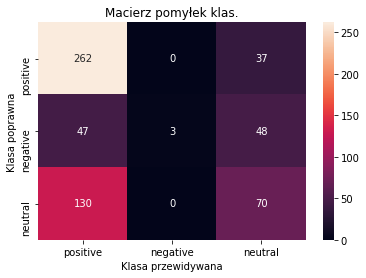

In [92]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred, labels=y_train['labels'].unique())

df = pd.DataFrame(conf_matrix, index=y_train['labels'].unique(), columns=y_train['labels'].unique())
sns.heatmap(df, annot=True, fmt='g')
plt.title('Macierz pomyłek klas.')
plt.xlabel('Klasa przewidywana')
plt.ylabel('Klasa poprawna')
plt.show()

In [93]:
print("Train accuracy = ", random_forest.score(X_train, y_train))
print("Test accuracy = ", random_forest.score(X_test, y_test))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s


Train accuracy =  0.9549516008935219


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s


Test accuracy =  0.5611390284757118


[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.3s finished


# **Prepare results**

In [50]:
test_csv = pd.read_csv(path_test, nrows=4000)
print(test_csv[:6])
print(type(test_csv))
print(test_csv.shape)

                   Id                                              Tweet
0  628949369883000832  dear @Microsoft the newOoffice for Mac is grea...
1  628976607420645377  @Microsoft how about you make a system that do...
2  629023169169518592                                      Not Available
3  629179223232479232                                      Not Available
4  629186282179153920  If I make a game as a #windows10 Universal App...
5  629226490152914944  Microsoft, I may not prefer your gaming branch...
<class 'pandas.core.frame.DataFrame'>
(4000, 2)


In [53]:
test_data = [
    [item['Id'], 
     pd.DataFrame(multiply_tf_idf(transform_tweet(item['Tweet'].lower()), idf_list).transpose(), columns=list_unique)] 
              for (index, item) in test_csv.iterrows()]
test_vectors = pd.concat([df for (id, df) in test_data])
test_vectors.index = [id for (id, df) in test_data]
X_test_pca = pca.transform(test_vectors)
print("original shape:   ", test_vectors.shape)
print("transformed shape:", X_test_pca.shape)

original shape:    (4000, 7073)
transformed shape: (4000, 500)


In [73]:
y_test_pred = pd.DataFrame(random_forest.predict(X_test_pca), columns=['Category'])
y_test_pred.index = [id for (id, df) in test_data]
y_test_pred.index.name = 'Id'
print(y_test_pred)
y_test_pred.to_csv('submission.csv')

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.6s finished


                    Category
Id                          
628949369883000832  positive
628976607420645377  positive
629023169169518592  positive
629179223232479232  positive
629186282179153920  positive
...                      ...
641411385700712448  positive
641452712098406400  positive
635369700298498048   neutral
635769805279248384  positive
635930169241374720   neutral

[4000 rows x 1 columns]
